# Flattening and glacier gridpoint selection tests:

- the tests take too long inside of the OGGM framework and would need all the flattened datasets. Therefore it is done here:
    - is the climate the same of the flattened and unflattened files?
        - check if GSWP3-W5E5 is equal to the flattened W5E5v2.0 in the common time period!
    - did we always select the nearest glacier gridpoints? (this was wrong for around 11900 glaciers in v2022.2, but should now work in v2023.2)
- also creates test GSWP3-W5E5 and ISIMIP3b files for pytest

In [1]:
# get my PR with updated paths
# install --no-deps "git+https://github.com/lilianschuster/oggm.git@376bfab70a94a6f9d0d88e6924c23e39423bc3a6"
#pip install --no-deps "git+https://github.com/OGGM/oggm.git@56018068f35c537670ee846f44bcf1ef78706707"

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
from oggm import utils
import sys
import pandas as pd
import os

**Let's get all glacier longitude / latitude to check later the distance to the nearest gridpoints:**

In [2]:
# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf['coords'] = [(lon,lat) for lon,lat in zip(odf['CenLon'],odf['CenLat'])]

In [3]:
odf

GLIMSId   BgnDate   EndDate    CenLon   CenLat  \
RGIId                                                                   
RGI60-01.00001  G213177E63689N  20090703  -9999999 -146.8230  63.6890   
RGI60-01.00002  G213332E63404N  20090703  -9999999 -146.6680  63.4040   
RGI60-01.00003  G213920E63376N  20090703  -9999999 -146.0800  63.3760   
RGI60-01.00004  G213880E63381N  20090703  -9999999 -146.1200  63.3810   
RGI60-01.00005  G212943E63551N  20090703  -9999999 -147.0570  63.5510   
...                        ...       ...       ...       ...      ...   
RGI60-19.02748  G322268E53986S  20020502  -9999999  -37.7325 -53.9860   
RGI60-19.02749  G323864E54831S  20030207  -9999999  -36.1361 -54.8310   
RGI60-19.02750  G322698E54188S  20030207  -9999999  -37.3018 -54.1884   
RGI60-19.02751  G269573E68866S  19870101  -9999999  -90.4266 -68.8656   
RGI60-19.02752  G037714E46897S  19660301  -9999999   37.7140 -46.8972   

               O1Region O2Region   Area  Zmin  Zmax  ...  TermType  Surging  \
RGIId                                                ...                      
RGI60-01.00001       01       02  0.360  1936  2725  ...         0        9   
RGI60-01.00002       01       02  0.558  1713  2144  ...         0        9   
RGI60-01.00003       01       02  1.685  1609  2182  ...         0        9   
RGI60-01.00004       01       02  3.681  1273  2317  ...         0        9   
RGI60-01.00005       01       02  2.573  1494  2317  ...         0        9   
...                 ...      ...    ...   ...   ...  ...       ...      ...   
RGI60-19.02748       19       03  0.042   310   510  ...         0        9   
RGI60-19.02749       19       03  0.567   330   830  ...         0        9   
RGI60-19.02750       19       03  4.118    10  1110  ...         1        9   
RGI60-19.02751       19       01  0.011   170   270  ...         1        9   
RGI60-19.02752       19       04  0.528   970  1170  ...         0        9   

                Linkages                      Name  GlacierType  \
RGIId                                                             
RGI60-01.00001         9                      None      Glacier   
RGI60-01.00002         9                      None      Glacier   
RGI60-01.00003         9                      None      Glacier   
RGI60-01.00004         9                      None      Glacier   
RGI60-01.00005         9                      None      Glacier   
...                  ...                       ...          ...   
RGI60-19.02748         9                      None      Glacier   
RGI60-19.02749         9                      None      Glacier   
RGI60-19.02750         9                      None      Glacier   
RGI60-19.02751         9              AQ6C10200013      Glacier   
RGI60-19.02752         9  ZA6C40100001 Ice Plateau      Glacier   

                      TerminusType       GlacierStatus  IsTidewater  \
RGIId                                                                 
RGI60-01.00001    Land-terminating  Glacier or ice cap        False   
RGI60-01.00002    Land-terminating  Glacier or ice cap        False   
RGI60-01.00003    Land-terminating  Glacier or ice cap        False   
RGI60-01.00004    Land-terminating  Glacier or ice cap        False   
RGI60-01.00005    Land-terminating  Glacier or ice cap        False   
...                            ...                 ...          ...   
RGI60-19.02748    Land-terminating  Glacier or ice cap        False   
RGI60-19.02749    Land-terminating  Glacier or ice cap        False   
RGI60-19.02750  Marine-terminating  Glacier or ice cap         True   
RGI60-19.02751  Marine-terminating  Glacier or ice cap         True   
RGI60-19.02752    Land-terminating  Glacier or ice cap        False   

                IsNominal                coords  
RGIId                                            
RGI60-01.00001      False    (-146.823, 63.689)  
RGI60-01.00002      False    (-146.668, 63.404)  
RGI60-01.00003      False     (-146.08, 63.376)  

## We start by the ultimative test that should work at the end (after reproducing preprocessing levels 3)

In [5]:
## todo: need to update that here when the new preprocessed files are there:
import glob
#sum_path = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/RGI62/b_010/L3/summary'
sum_path = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands/W5E5/RGI62/b_160/L3/summary'

all_files = glob.glob(f'{sum_path}/glacier_statistics_*.csv')

li = []
for filename in all_files:
    odf_prepro = pd.read_csv(filename, low_memory=False)
    li.append(odf_prepro)

odf_prepro = pd.concat(li, axis=0, ignore_index=True)
condi1 = np.abs(odf_prepro.cenlon - odf_prepro.baseline_climate_ref_pix_lon)>0.25
condi2 = np.abs(odf_prepro.cenlat - odf_prepro.baseline_climate_ref_pix_lat)>0.25
assert len(odf_prepro.loc[condi1 | condi2]) == 0

In [7]:
odf_prepro

rgi_id  rgi_region rgi_subregion                 name  \
0       RGI60-02.00001           2         02-04                  NaN   
1       RGI60-02.00002           2         02-04                  NaN   
2       RGI60-02.00003           2         02-04                  NaN   
3       RGI60-02.00004           2         02-04                  NaN   
4       RGI60-02.00005           2         02-04                  NaN   
...                ...         ...           ...                  ...   
215542  RGI60-08.03413           8         08-01                  NaN   
215543  RGI60-08.03414           8         08-01                  NaN   
215544  RGI60-08.03415           8         08-01                  NaN   
215545  RGI60-08.03416           8         08-01  Austre Okstindbreen   
215546  RGI60-08.03417           8         08-01                  NaN   

         cenlon   cenlat  rgi_area_km2  rgi_year glacier_type  \
0      -121.235  49.0019         0.073      2004      Glacier   
1      -121.590  49.1617         0.262      2004      Glacier   
2      -121.209  49.1627         0.307      2004      Glacier   
3      -121.601  49.1657         0.184      2004      Glacier   
4      -121.611  49.1666         0.274      2004      Glacier   
...         ...      ...           ...       ...          ...   
215542   16.604  68.1640         0.098      2001      Glacier   
215543   15.213  66.5900         0.389      1999      Glacier   
215544   15.203  66.7290         0.056      1999      Glacier   
215545   14.296  66.0060        14.152      1999      Glacier   
215546   14.221  65.9230         0.150      1999      Glacier   

           terminus_type  ...       reference_period temp_default_gradient  \
0       Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
1       Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
2       Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
3       Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
4       Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
...                  ...  ...                    ...                   ...   
215542  Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
215543  Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
215544  Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
215545  Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   
215546  Land-terminating  ...  2000-01-01_2020-01-01               -0.0065   

        temp_all_solid  temp_all_liq  temp_melt  dem_needed_interpolation  \
0                  0.0           2.0       -1.0                       NaN   
1                  0.0           2.0       -1.0                       NaN   
2                  0.0           2.0       -1.0                       NaN   
3                  0.0           2.0       -1.0                       NaN   
4                  0.0           2.0       -1.0                       NaN   
...                ...           ...        ...                       ...   
215542             0.0           2.0       -1.0                       NaN   
215543             0.0           2.0       -1.0                       NaN   
215544             0.0           2.0       -1.0                       NaN   
215545             0.0           2.0       -1.0                       NaN   
215546             0.0           2.0       -1.0                       NaN   

       dem_invalid_perc dem_needed_extrapolation  dem_extrapol_perc  \
0                   NaN                      NaN                NaN   
1                   NaN                      NaN                NaN   
2                   NaN                      NaN                NaN   
3                   NaN                      NaN                NaN   
4                   NaN                      NaN                NaN   
...                 ...                      ...                ...   

In [6]:
print('amount of glaciers that do not take the nearest climate gridpoint:')
print(len(odf_prepro.loc[condi1 | condi2]))
odf_prepro.loc[condi1 | condi2].groupby('rgi_region').count()

amount of glaciers that do not take the nearest climate gridpoint:
0


Empty DataFrame
Columns: [rgi_id, rgi_subregion, name, cenlon, cenlat, rgi_area_km2, rgi_year, glacier_type, terminus_type, is_tidewater, status, inv_volume_km3, vas_volume_km3, inv_volume_bsl_km3, inv_volume_bwl_km3, dem_source, flowline_type, apparent_mb_from_any_mb_residual, inversion_glen_a, inversion_fs, error_task, error_msg, dem_mean_elev, dem_med_elev, dem_min_elev, dem_max_elev, dem_max_elev_on_ext, dem_min_elev_on_ext, dem_perc_area_above_max_elev_on_ext, terminus_lon, terminus_lat, main_flowline_length, inv_flowline_glacier_area, flowline_mean_elev, flowline_max_elev, flowline_min_elev, flowline_avg_slope, flowline_avg_width, flowline_last_width, flowline_last_5_widths, baseline_climate_source, baseline_yr_0, baseline_yr_1, baseline_climate_ref_hgt, baseline_climate_ref_pix_lon, baseline_climate_ref_pix_lat, bias, melt_f, prcp_fac, temp_bias, reference_mb, reference_mb_err, reference_period, temp_default_gradient, temp_all_solid, temp_all_liq, temp_melt, dem_needed_interpolation, dem_invalid_perc, dem_needed_extrapolation, dem_extrapol_perc, dem_invalid_perc_in_mask]
Index: []

[0 rows x 62 columns]

### The same can be tested in a more complicated way for the different flattened files:
- a short version is inside `test_shop.test_glacier_gridpoint_selection`

In [7]:
def test_glacier_gridpoint_selection(path_l, short = True, print_stuff=False):
    for p in path_l:
        if 'inv' not in p:
            with xr.open_dataset(p) as dt:
                dt = dt.isel(time=0) # we only need the lat/lon anyways
        else:
            dt = xr.open_dataset(p)
        if short:
            # select three glaciers where two failed in the
            # previous gswp3_w5e5 version
            coords = [(10.7584, 46.8003),  # HEF
                          (-70.8931, -72.4474),  # RGI60-19.00124
                          (51.495, 30.9010),  # RGI60-12.01691
                          ]
        else:
            coords = odf['coords']
        for coord in coords:
            lon, lat = coord
            if lon <0:
                lon = lon + 360
            # get the distances to the glacier coordinate
            c = ((dt.longitude - lon) ** 2 + (dt.latitude - lat) ** 2)**0.5
            # select the nearest climate point from the flattened
            # glacier gridpoint
            if 'inv' in p:
                lat_near, lon_near, dist = c.to_dataframe('distance').sort_values('distance').iloc[0]
                # for a randomly chosen gridpoint, the next climate gridpoint is far away
                # for glacier gridpoints the next gridpoint should be the nearest
                # (GSWP3-W5E5 resolution is 0.5°)
                if print_stuff:
                    print(p, dist, lat_near, lat, lon_near, lon)
                assert dist <= (0.25 ** 2 + 0.25 ** 2) ** 0.5
                assert np.abs(lat_near - lat) <= 0.25
                assert np.abs(lon_near - lon) <= 0.25
            else:
                dist = c.to_dataframe('distance').sort_values('distance').distance.iloc[0]
                if print_stuff:
                    print(p, dist, lon, lat)
                assert dist <= (0.25 ** 2 + 0.25 ** 2) ** 0.5

In [8]:
### for that to run need the latest OGGM 
# select directly the OGGM w5e5 files
short = True
from oggm.shop import w5e5
d = 'GSWP3_W5E5'

path_l = []
for var in ['inv','tmp', 'temp_std', 'prcp']:
    path_l.append(w5e5.get_gswp3_w5e5_file(d, var))
    

test_glacier_gridpoint_selection(path_l, short = short, print_stuff=True)


/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.05099656851200873 46.75 46.8003 10.75 10.7584
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.2438121613045622 -72.25 -72.4474 289.25 289.1069
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc 0.28779506597577154 30.75 30.901 51.25 51.495
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019_flat_glaciers.nc 0.05099656851200873 10.7584 46.8003
/home/data/download/cluster.klima.uni-bremen.de/~oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019_flat_glaciers.nc 0.2438121613045622 289.1069 -72.4474
/home/data/download/cluster.klima.uni-bremen.de/~og

- w5e5 files:

In [9]:
w5e5_files = []
#folder_w5e5 = www_lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc
os.listdir('/home/www/lschuster/w5e5v2.0/flattened/2023.2')

w5e5_files = []
w5e5_files_l = []
w5e5_files.append('/home/www/lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc')
w5e5_files_l.append('/home/www/lschuster/w5e5v2.0/flattened/2023.2/w5e5v2.0_glacier_invariant_flat.nc')

folder_p = '/home/www/lschuster/w5e5v2.0/flattened/2023.2/monthly/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        w5e5_files.append(folder_p+p)
# add the last one inside for the long test
w5e5_files_l.append(folder_p + os.listdir(folder_p)[1])

folder_p = '/home/www/lschuster/w5e5v2.0/flattened/2023.2/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        w5e5_files.append(folder_p+p)
# add the last one inside for the long test
w5e5_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(w5e5_files, short = True, print_stuff=False)


In [10]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(w5e5_files_l, short = False)

- isimip3b

In [24]:
isimip3b_files = []
isimip3b_files_l = []
#isimip3b_files.append('/home/www/lschuster/isimip3b_flat/flat/2023.2/isimip3b_glacier_invariant_flat.nc')
#isimip3b_files_l.append('/home/www/lschuster/isimip3b_flat/flat/2023.2/isimip3b_glacier_invariant_flat.nc')
isimip3b_files.append('/home/www/oggm/cmip6/isimip3b/flat/2023.2/isimip3b_glacier_invariant_flat.nc')
isimip3b_files_l.append('/home/www/oggm/cmip6/isimip3b/flat/2023.2/isimip3b_glacier_invariant_flat.nc')

folder_p = '/home/www/oggm/cmip6/isimip3b/flat/2023.2/monthly/'
for p in os.listdir(folder_p):
    isimip3b_files.append(folder_p+p)
# add the last one inside for the long test
isimip3b_files_l.append(folder_p+p)

folder_p = '/home/www/oggm/cmip6/isimip3b/flat/2023.2/daily/'
for p in os.listdir(folder_p):
    isimip3b_files.append(folder_p+p)
# add the last one inside for the long test
isimip3b_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3b_files, short = True)


In [11]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(isimip3b_files_l, short = False)

- isimip3a

In [21]:
isimip3a_files = []
isimip3a_files_l = []
isimip3a_files.append('/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc')
isimip3a_files_l.append('/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc')

folder_p = '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        isimip3a_files.append(folder_p+p)
# add the last one inside for the long test
isimip3a_files_l.append(isimip3a_files[-1])

folder_p = '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/daily/'
for p in os.listdir(folder_p):
    isimip3a_files.append(folder_p+p)
# add the last one inside for the long test
isimip3a_files_l.append(folder_p+p)
test_glacier_gridpoint_selection(isimip3a_files, short = True, print_stuff=False)


In [13]:
# do the long test only for three files in total
test_glacier_gridpoint_selection(isimip3a_files_l, short = False)

In [27]:
_d = xr.open_dataset('/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_temp_std_global_monthly_1901_2019_flat_glaciers.nc')
_d = _d.rename_vars(dict(tas_std='temp_std'))


In [30]:
_d.to_netcdf('/home/www/lschuster/isimip3a/flattened/2023.2/monthly/xgswp3-w5e5_obsclim_temp_std_global_monthly_1901_2019_flat_glaciers.nc')

In [29]:
_d.to_netcdf('/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/xgswp3-w5e5_obsclim_temp_std_global_monthly_1901_2019_flat_glaciers.nc')

In [22]:
isimip3a_files

['/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc',
 '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019_flat_glaciers.nc',
 '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_pr_global_monthly_1901_2019_flat_glaciers.nc',
 '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_obsclim_temp_std_global_monthly_1901_2019_flat_glaciers.nc',
 '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/monthly/gswp3-w5e5_glacier_invariant_flat.nc',
 '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/daily/gswp3-w5e5_obsclim_pr_global_daily_1901_2019_flat_glaciers.nc',
 '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/daily/gswp3-w5e5_glacier_invariant_flat.nc',
 '/home/www/oggm/climate/gswp3-w5e5/flattened/2023.2/daily/gswp3-w5e5_obsclim_tas_global_daily_1901_2019_flat_glaciers.nc']

## Is the climate the same of the flattened and unflattened files?

- gswp3-w5e5 / isimip3a : 

In [83]:
# check for every glacier gridpoint if the correct climate dataset 
# was used by comparing it to the unflattened file:
# this takes some time (we only do this for the monthly files like that, it would take too long for the daily files)

# path_clim = '/home/www/oggm/climate/gswp3-w5e5/'
for version in ['2022_missing_points', '2023.2']:
    for var in ['pr', 'tas']:
        fp = f'/home/www/lschuster/isimip3a/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc'
        ds_flattened = xr.open_dataset(fp)
        fp_unflat = '/home/www/lschuster/isimip3a/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019.nc'.format(var)
        ds_unflattened = xr.open_dataset(fp_unflat)

        for p in ds_flattened.points:
            # get the point
            ds_flattened_sel = ds_flattened.sel(points=p)
            # select longitude, latitude and tas of that point
            lon_p = ds_flattened_sel.longitude
            lat_p = ds_flattened_sel.latitude
            var_p = ds_flattened_sel[var]
            # select the same gridpoint from the unflattened file
            # the unflattened file is in -180, 180
            if lon_p >=180:
                lon_p = lon_p-360
            # check if the unflattened and the flattened file have the same climate
            # data inside
            np.testing.assert_allclose(var_p.values,
                                       ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


In [ ]:
# the same test for the data directly in www/oggm -> they should be the same:
path_clim = '/home/www/oggm/climate/gswp3-w5e5/'

for var in ['pr', 'tas']:
    fp = path_clim + 'flattened/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019_flat_glaciers.nc'.format(var)
    ds_flattened = xr.open_dataset(fp)
    fp_unflat = path_clim + 'unflattened/monthly/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019.nc'.format(var)
    ds_unflattened = xr.open_dataset(fp_unflat)
    
    # check for every glacier gridpoint if the correct climate dataset 
    # was used by comparing it to the unflattened file:
    for p in ds_flattened.points:
        # get the point
        ds_flattened_sel = ds_flattened.sel(points=p)
        # select longitude, latitude and tas of that point
        lon_p = ds_flattened_sel.longitude
        lat_p = ds_flattened_sel.latitude
        var_p = ds_flattened_sel[var]
        # select the same gridpoint from the unflattened file
        # the unflattened file is in -180, 180
        if lon_p >=180:
            lon_p = lon_p-360
        # check if the unflattened and the flattened file have the same climate
        # data inside
        np.testing.assert_allclose(var_p.values,
                                   ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


- w5e5v2.0: check if the flattened file is the same as the gswps-w5e5 file over the common period

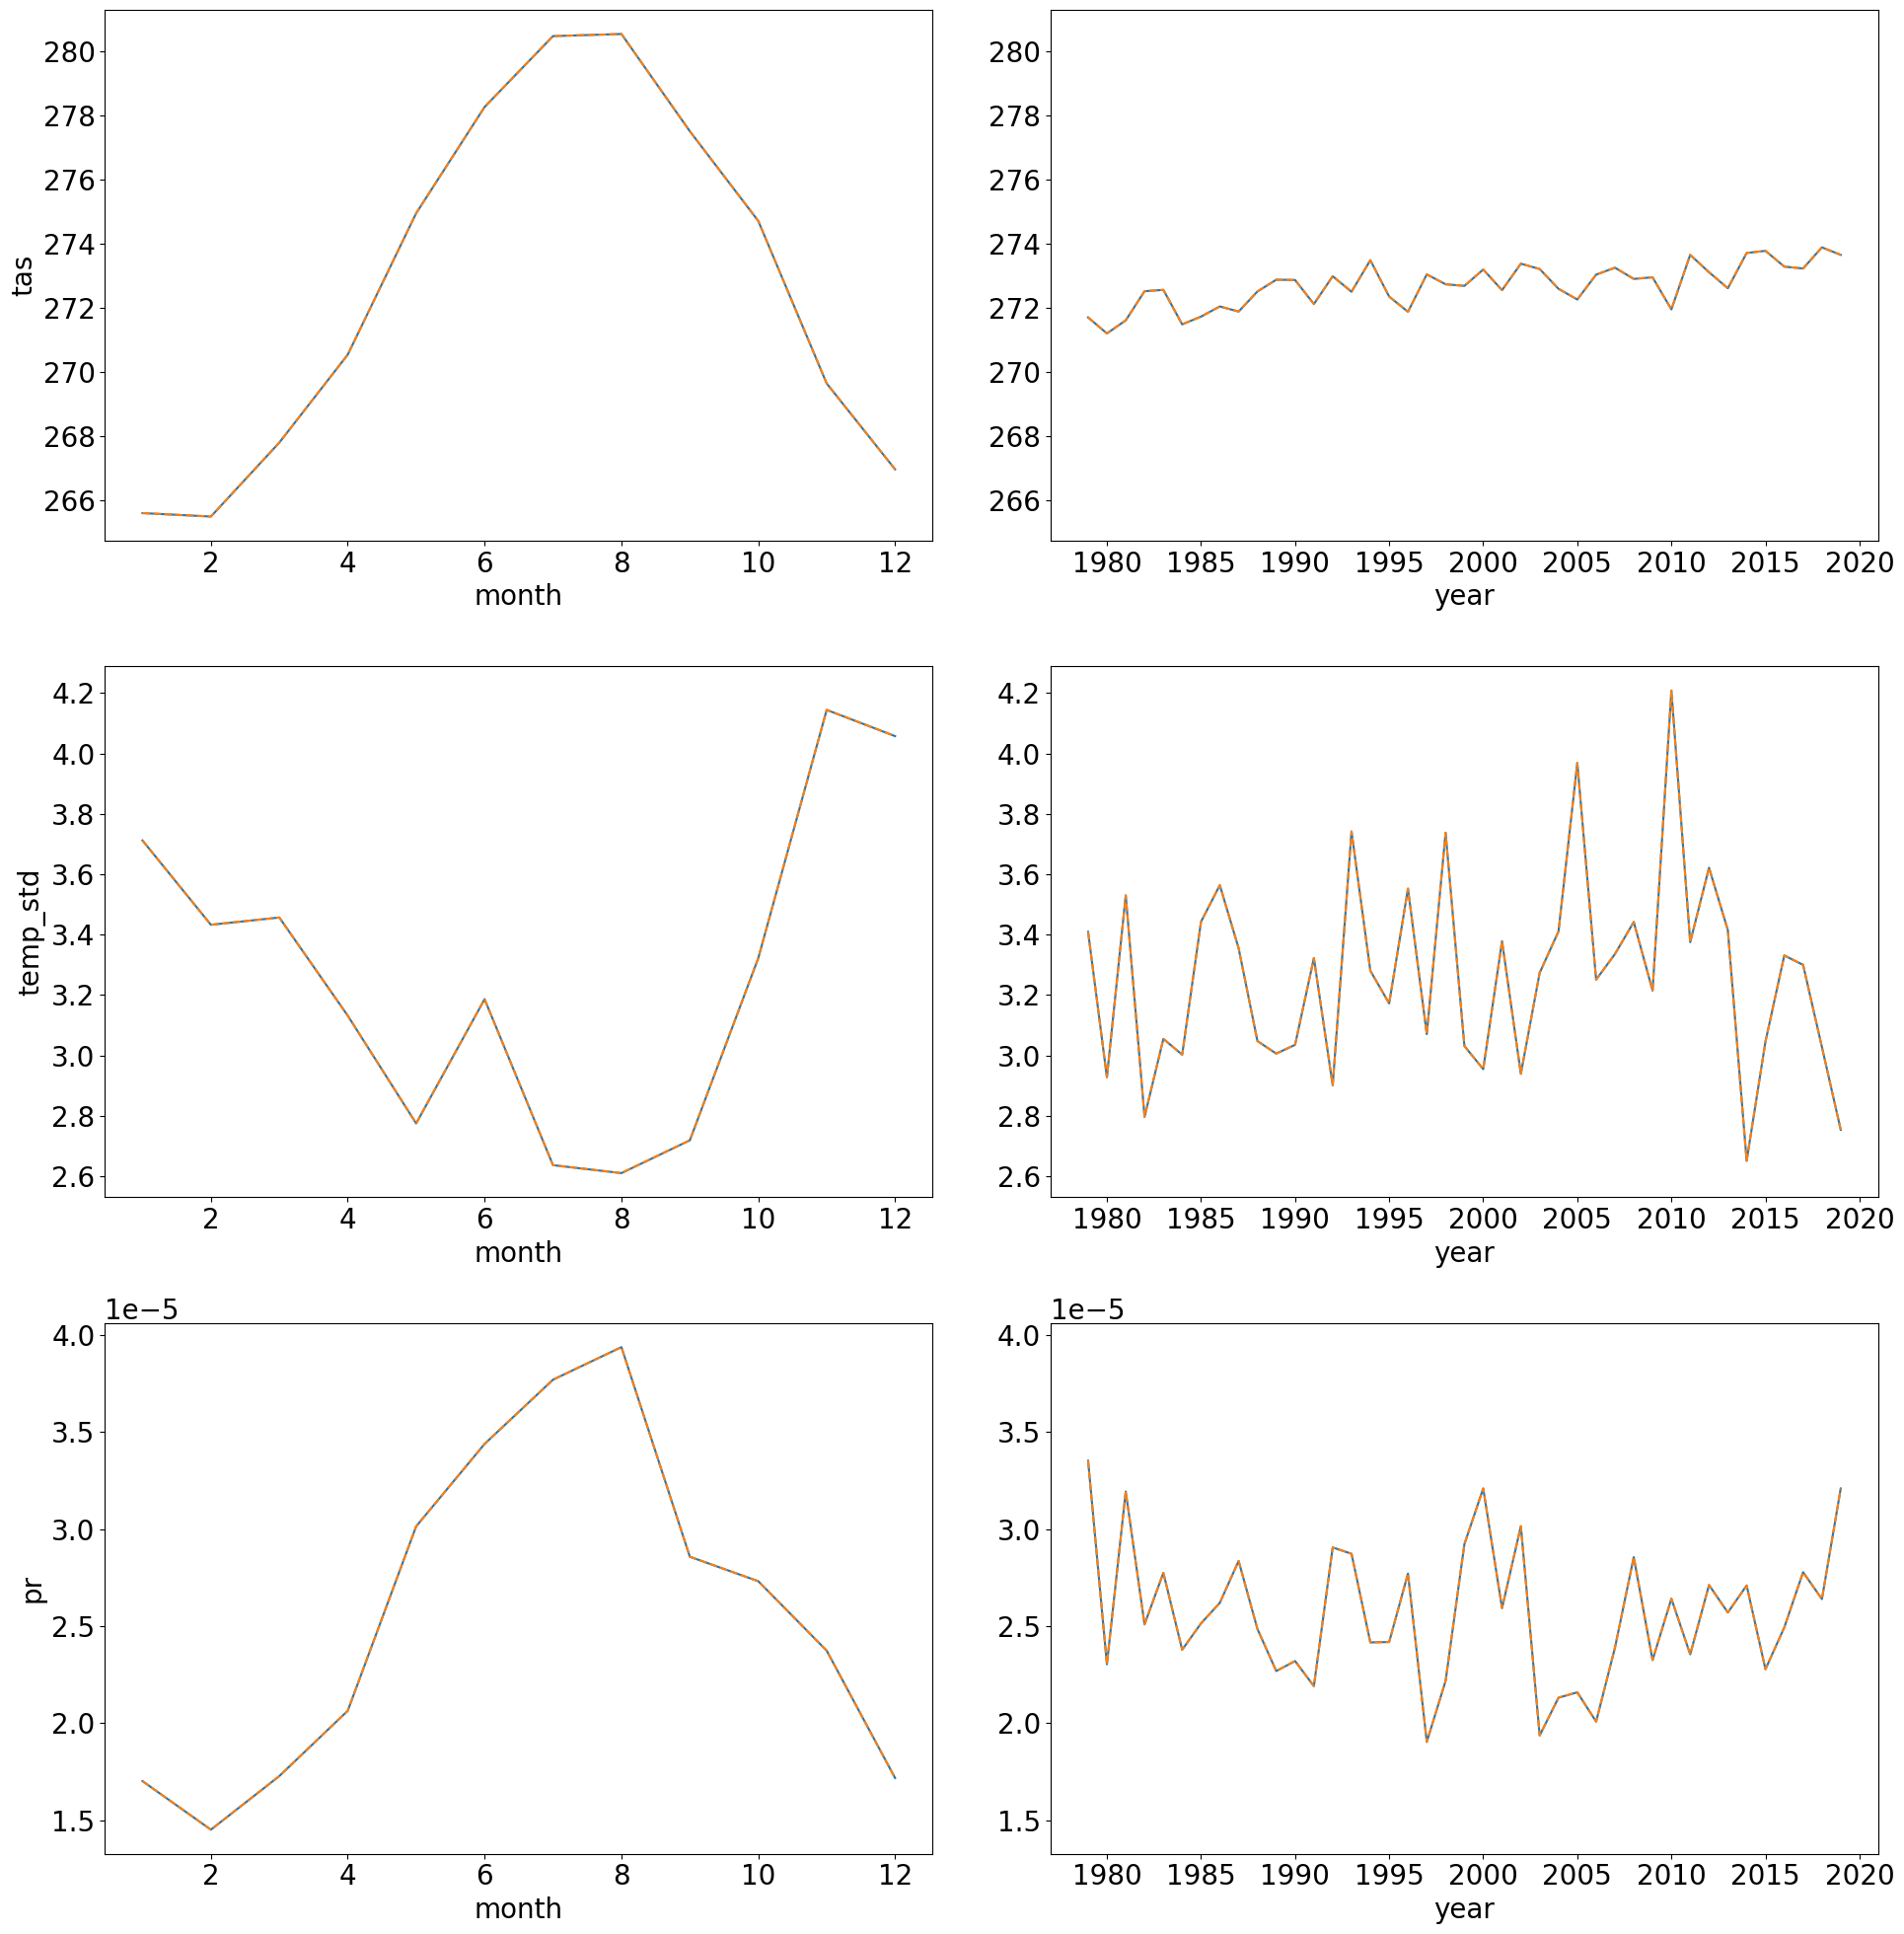

In [99]:
plt.rcParams['font.size'] = 20
j = 0
plt.figure(figsize=(20,20))
#plt.rcsize(20)
for var in ['tas', 'temp_std', 'pr']:
    if var == 'temp_std':
        var_w5e5 = 'tas_std'
    else:
        var_w5e5 = var
    for version in  ['2023.2']: #['2022_missing_points',
        
        if version == '2022_missing_points':
            path_w5e5 = f'/home/www/lschuster/w5e5v2.0/flattened/monthly/w5e5v2.0_{var_w5e5}_global_monthly_flat_glaciers_1979_2019.nc'
            pathi = f'/home/www/oggm/climate/gswp3-w5e5/flattened/monthly'

        else:
            path_w5e5 = f'/home/www/lschuster/w5e5v2.0/flattened/{version}/monthly/w5e5v2.0_{var_w5e5}_global_monthly_flat_glaciers_1979_2019.nc'
            pathi = f'/home/www/oggm/climate/gswp3-w5e5/flattened/{version}/monthly'

        ds_w5e5 = xr.open_dataset(path_w5e5)
    
        ds_gswp3_w5e5 = xr.open_dataset(pathi+'/gswp3-w5e5_obsclim_{}_global_monthly_1901_2019_flat_glaciers.nc'.format(var))
        # let's only look at the common time period!!!
        ds_gswp3_w5e5 = ds_gswp3_w5e5.sel(time=ds_w5e5.time)

        # this here is the main test, for all months and for all gridpoints, check if they coincide:
        # yes, they do!!!
        if var !='pr':
            np.testing.assert_allclose(ds_w5e5[var_w5e5], ds_gswp3_w5e5[var_w5e5], rtol=1e-6)
        else:
            # prcp is in daily mean values (kg m-2 s-1) and has much smaller values than temperatures, so datasets should be more similar
            np.testing.assert_allclose(ds_w5e5[var_w5e5], ds_gswp3_w5e5[var_w5e5], rtol=1e-9)


        # visual test just for HEF:
        lon, lat = (10.7584, 46.8003)
        c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
        plt.subplot(3,2,j+1)
        plt.plot(np.arange(1,13,1), ds_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.month').mean())
        plt.plot(np.arange(1,13,1), ds_gswp3_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.month').mean(),ls='--')
        j+=1
        plt.ylabel(var)
        ax=plt.gca()
        plt.xlabel('month')

        plt.subplot(3,2,j+1, sharey=ax)
        plt.plot(np.arange(1979,2020,1), ds_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.year').mean())
        plt.plot(np.arange(1979,2020,1), ds_gswp3_w5e5[var_w5e5].sel(points=c.argmin()).groupby('time.year').mean(), ls='--')
        j+=1
    plt.xlabel('year')
    
plt.tight_layout()

In [ ]:
# check for every glacier gridpoint if the correct climate dataset 
# was used by comparing it to the unflattened file:
# this takes some time (we only do this for the monthly files like that, it would take too long for the daily files)

# path_clim = '/home/www/oggm/climate/gswp3-w5e5/'
# don't run this ... 

run = False
if run:
    for version in ['2022_missing_points', '2023.2']:
        for var in ['pr', 'tas']:
            if version == '2022_missing_points':
                fp = f'/home/www/lschuster/w5e5v2.0/flattened/monthly/w5e5v2.0_{var}_global_monthly_flat_glaciers_1979_2019.nc'
            else:
                fp = f'/home/www/lschuster/w5e5v2.0/flattened/{version}/monthly/w5e5v2.0_{var}_global_monthly_flat_glaciers_1979_2019_.nc'
            ds_flattened = xr.open_dataset(fp)
            fp_unflat = f'/home/www/lschuster/w5e5v2.0/_script/{var}_W5E5v2.0_*.nc'
            with xr.open_mfdataset(fp_unflat) as ds_unflattened:
                ds_unflattened = ds_unflattened.resample(time='MS').mean()
            for p in ds_flattened.points[:100]:
                # get the point
                ds_flattened_sel = ds_flattened.sel(points=p)
                # select longitude, latitude and tas of that point
                lon_p = ds_flattened_sel.longitude.isel(time=0)
                lat_p = ds_flattened_sel.latitude.isel(time=0)
                var_p = ds_flattened_sel[var]
                # select the same gridpoint from the unflattened file
                # the unflattened file is in -180, 180
                if lon_p >=180:
                    lon_p = lon_p-360
                # check if the unflattened and the flattened file have the same climate
                # data inside
                np.testing.assert_allclose(var_p.values,
                                           ds_unflattened[var].sel(lon = lon_p, lat=lat_p))


## Create climate test files:
- this is for pytest in order that during the tests only a small part of the climate datasets are downloaded (just the nearest 4 points of HEF)!
(these ones did not change between the versions)
- but these test files can not really be used to check if the right glacier gridpoints are selected, for that we use jsut the entire `inv` file which quite small (~100kb)

In [32]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

#test_clim_path = '/home/www/lschuster/isimip3a/test_climate'
test_clim_path = '/home/www/oggm/test_climate/gswp3-w5e5'
for version in ['2022_missing_points', '2023.2']:
    for var in ['tas', 'temp_std', 'pr', 'inv']:
        if var == 'inv':
            ds = xr.open_dataset(f'/home/www/lschuster/isimip3a/flattened/{version}/gswp3-w5e5_glacier_invariant_flat.nc')
            # we just compy the entire invariant file inside because it does not make a big storage difference
            ds.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_glacier_invariant_flat.nc')
        else:
            ds = xr.open_dataset(f'/home/www/lschuster/isimip3a/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc')
        
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            p_nearest = np.concatenate([p_nearest,p2_nearest])

            ds_test = ds.isel(points=p_nearest)
   
            ds_test.to_netcdf(f'{test_clim_path}/flattened/{version}/monthly/gswp3-w5e5_obsclim_{var}_global_monthly_1901_2019_flat_glaciers.nc')

#www_lschuster/isimip3a/flattened/2022_missing_points/gswp3_w5e5_glacier_invariant_flat.nc

In [33]:
# HEF location
lon, lat = (10.7584, 46.8003)
# RGI60-19.00124
lon2,lat2 = (-70.8931 +360, -72.4474)

test_clim_path = '/home/www/oggm/test_climate'
for version in ['2022_missing_points', '2023.2']:
    for var in ['tasAdjust', 'prAdjust']:
        for ssp in ['ssp126', 'ssp585']:
            if version == '2022_missing_points':
                ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            else:
                ds = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            c = (ds.longitude - lon)**2 + (ds.latitude - lat)**2
            p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

            c2 = (ds.longitude - lon2)**2 + (ds.latitude - lat2)**2
            p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

            p_nearest = np.concatenate([p_nearest,p2_nearest])

            ds_test = ds.isel(points=p_nearest)
            ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_{ssp}_{var}_global_monthly_flat_glaciers.nc')
            ds.close()
        if version == '2022_missing_points':
             ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        else:
            ds_h = xr.open_dataset(f'/home/www/oggm/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        
        c = (ds_h.longitude - lon)**2 + (ds_h.latitude - lat)**2
        p_nearest = c.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to HEF

        c2 = (ds_h.longitude - lon)**2 + (ds_h.latitude - lat)**2
        p2_nearest = c2.to_dataframe('distance').sort_values('distance').index[:4].values # 4 nearest points to glacier 2

        p_nearest = np.concatenate([p_nearest,p2_nearest])

        ds_test = ds_h.isel(points=p_nearest)
        ds_test.to_netcdf(f'{test_clim_path}/cmip6/isimip3b/flat/{version}/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_{var}_global_monthly_flat_glaciers.nc')
        ds_h.close()



### Check of Sarah's downscaled flattened data:

In [14]:
sarah_files_l = []

folder_p = '/home/www/shanus/ISIMIP3a/flattened/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        sarah_files_l.append(folder_p+p)

folder_p = '/home/www/shanus/ISIMIP3b/flattened/daily/'
for p in os.listdir(folder_p):
    if '.nc' in p:
        sarah_files_l.append(folder_p+p)
        
def test_glacier_gridpoint_selection_sarah(p, short = True, print_stuff=False, max_dist=0.0417):
    # file path (ISIMIP3a or ISIMIP3b)
    if 'inv' not in p:
        with xr.open_dataset(p) as dt:
            dt = dt.isel(time=0) # we only need the lat/lon anyways
    else:
        dt = xr.open_dataset(p)
    if short:
        # select three glaciers where two failed in the
        # previous gswp3_w5e5 version
        coords = [(10.7584, 46.8003),  # HEF
                      (-70.8931, -72.4474),  # RGI60-19.00124
                      (51.495, 30.9010),  # RGI60-12.01691
                      ]
    else:
        coords = odf['coords']
    for coord in coords:
        lon, lat = coord
        if lon <0:
            lon = lon + 360
        # get the distances to the glacier coordinate
        c = ((dt.longitude - lon) ** 2 + (dt.latitude - lat) ** 2)**0.5
        # select the nearest climate point from the flattened
        # glacier gridpoint
        if 'inv' in p:
            lat_near, lon_near, dist = c.to_dataframe('distance').sort_values('distance').iloc[0]
            # for a randomly chosen gridpoint, the next climate gridpoint is far away
            # for glacier gridpoints the next gridpoint should be the nearest
            # (GSWP3-W5E5 resolution is 0.5°)
            if print_stuff:
                print(p, dist, lat_near, lat, lon_near, lon)
                print(lat_near-lat)
            assert dist <= (max_dist ** 2 + max_dist ** 2) ** 0.5
            assert np.abs(lat_near - lat) <= max_dist
            assert np.abs(lon_near - lon) <= max_dist
        else:
            dist = c.to_dataframe('distance').sort_values('distance').distance.iloc[0]
            if print_stuff:
                print(p, dist, lon, lat)
            assert dist <= (max_dist ** 2 + max_dist ** 2) ** 0.5
for p in sarah_files_l:
    print(p)
    test_glacier_gridpoint_selection_sarah(p,short=False,print_stuff=False)

ok, it looks good in case of sarah's files: (I just checked the first ISIMIP3a /3b files but that should be sufficient:

In [ ]:
for p in sarah_files_l:
    print(p)
    test_glacier_gridpoint_selection_sarah(p,short=False,print_stuff=False)

/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_glacier_invariant_flat.nc
/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_tas_global_daily_flat_glaciers_1979_2019.nc
/home/www/shanus/ISIMIP3a/flattened/daily/gswp3-w5e5_obsclim_pr_global_daily_flat_glaciers_1979_2019.nc
/home/www/shanus/ISIMIP3b/flattened/daily/ipsl-cm6a-lr_r1i1p1f1_w5e5_ssp370_prAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/ipsl-cm6a-lr_r1i1p1f1_w5e5_ssp585_prAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp126_tasAdjust_global_daily_flat_glaciers_2015_2100.nc
/home/www/shanus/ISIMIP3b/flattened/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp370_tasAdjust_global_daily_flat_glaciers_2015_2100.nc
